Phân bố nhãn ban đầu:
2    7
1    7
0    7
4    7
3    7
Name: count, dtype: int64

Phân bố nhãn sau tăng cường:
2    350
1    350
0    350
4    350
3    350
Name: count, dtype: int64
Số đặc trưng sau PCA: 9
✅ Fold 1 hợp lệ.
✅ Fold 2 hợp lệ.
✅ Fold 3 hợp lệ.
✅ Fold 4 hợp lệ.
✅ Fold 5 hợp lệ.

Tổng số fold hợp lệ: 5/5
Tham số tốt nhất: {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}

Độ chính xác trung bình (Cross-validation): 92.69%
Độ lệch chuẩn (Cross-validation): 0.93%

Độ chính xác trên tập kiểm tra: 92.29%

Báo cáo phân loại (tập kiểm tra):
                   precision    recall  f1-score   support

          Healthy       1.00      1.00      1.00        70
  Surface Erosion       0.89      0.90      0.89        70
    Cracked Blade       0.92      0.96      0.94        70
   Mass Imbalance       0.88      0.91      0.90        70
Twist Blade Fault       0.94      0.84      0.89        70

         accuracy                           0.92       350
        macro avg       0.92      0.92  

c:\Users\LENOVO\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
10 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\LENOVO\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\LENOVO\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\LENOVO\Ap

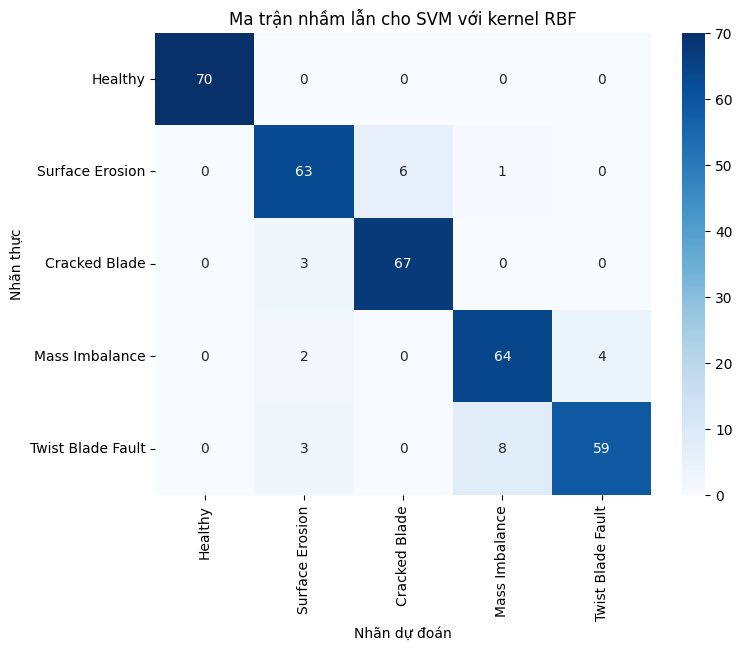

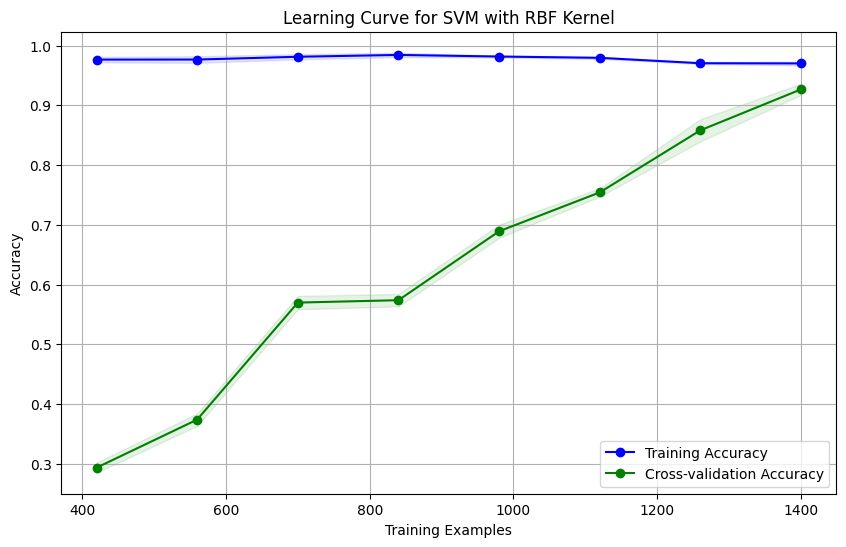

Đã lưu mô hình, scaler và PCA vào 'wind_turbine_svm_rbf_model_optimized_v5.pkl', 'wind_turbine_svm_scaler_optimized_v5.pkl' và 'wind_turbine_pca_optimized_v5.pkl'


In [19]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve, cross_val_score, StratifiedKFold
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.decomposition import PCA
from scipy import stats, fft
import random
import matplotlib.pyplot as plt

# Hàm trích xuất đặc trưng từ tín hiệu
def extract_features(sequence):
    amplitude = sequence[:, 0]  # Cột amplitude
    wind_speed = sequence[:, 1]  # Cột wind_speed

    # Đặc trưng miền thời gian
    features = []
    features.append(np.mean(amplitude))
    features.append(np.std(amplitude))
    features.append(np.max(amplitude))
    features.append(np.min(amplitude))
    features.append(stats.skew(amplitude))
    features.append(stats.kurtosis(amplitude))
    features.append(np.mean(wind_speed))
    features.append(np.std(wind_speed))

    # Thêm đặc trưng mới: Tỷ lệ biến thiên biên độ
    amplitude_diff = np.diff(amplitude)
    amplitude_variation_ratio = np.std(amplitude_diff) / (np.mean(np.abs(amplitude)) + 1e-10)
    features.append(amplitude_variation_ratio)

    # Đặc trưng miền tần số
    fft_vals = np.abs(fft.fft(amplitude))
    fft_vals = fft_vals[:len(fft_vals) // 2]
    peak_freq = np.argmax(fft_vals)
    features.append(peak_freq)
    spectral_energy = np.sum(fft_vals ** 2)
    features.append(spectral_energy)
    fft_probs = fft_vals / np.sum(fft_vals)
    spectral_entropy = -np.sum(fft_probs * np.log2(fft_probs + 1e-10))
    features.append(spectral_entropy)

    return np.array(features)

# Đọc dữ liệu
df = pd.read_csv("merged_wind_turbine_data.csv")

# Tái cấu trúc dữ liệu thành các chuỗi
sequences = []
labels = []
sequence_length = 500

for i in range(0, len(df), sequence_length):
    sequence_data = df.iloc[i:i + sequence_length]
    if len(sequence_data) == sequence_length:
        sequence = sequence_data[['amplitude', 'wind_speed']].values
        label = sequence_data['label'].iloc[0]
        sequences.append(sequence)
        labels.append(label)

sequences = np.array(sequences)
labels = np.array(labels)

# Kiểm tra phân bố nhãn ban đầu
print("Phân bố nhãn ban đầu:")
print(pd.Series(labels).value_counts())

# Tăng cường dữ liệu
augmented_sequences = []
augmented_labels = []
noise_factor = 0.02
shift_max = 50
scale_factor_range = (0.9, 1.1)

for i in range(len(sequences)):
    for _ in range(50):  # Tăng lên 50 biến thể
        # Thêm nhiễu
        noise = np.random.normal(0, noise_factor, sequences[i].shape)
        seq_noisy = sequences[i] + noise
        # Dịch chuyển thời gian
        shift = random.randint(-shift_max, shift_max)
        seq_shifted = np.roll(seq_noisy, shift, axis=0)
        # Phóng to/thu nhỏ biên độ
        scale = random.uniform(scale_factor_range[0], scale_factor_range[1])
        seq_scaled = seq_shifted.copy()
        seq_scaled[:, 0] = seq_scaled[:, 0] * scale
        # Đảo ngược tín hiệu
        if random.random() > 0.5:
            seq_scaled = np.flip(seq_scaled, axis=0)
        augmented_sequences.append(seq_scaled)
        augmented_labels.append(labels[i])

augmented_sequences = np.array(augmented_sequences)
augmented_labels = np.array(augmented_labels)

# Kiểm tra phân bố nhãn sau tăng cường
print("\nPhân bố nhãn sau tăng cường:")
print(pd.Series(augmented_labels).value_counts())

# Trích xuất đặc trưng
X_features = np.array([extract_features(seq) for seq in augmented_sequences])

# Chuẩn hóa và giảm chiều dữ liệu với PCA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_features)
pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(X_scaled)
print(f"Số đặc trưng sau PCA: {X_reduced.shape[1]}")

# Chia dữ liệu
X_train, X_test, y_train, y_test = train_test_split(X_reduced, augmented_labels, test_size=0.2, random_state=42, stratify=augmented_labels)

# Huấn luyện SVM với GridSearchCV (kernel RBF)
param_grid = {
    'C': [0.01, 0.1, 1, 10],  # Mở rộng phạm vi C
    'gamma': ['scale', 0.001, 0.01, 0.1],  # Mở rộng phạm vi gamma
    'kernel': ['rbf']
}
svm = SVC()
# Hàm kiểm tra fold hợp lệ
def get_valid_folds(X, y, n_splits=5, random_state=42, verbose=False):
    """
    Trả về danh sách các fold hợp lệ từ StratifiedKFold,
    mỗi fold đảm bảo có ít nhất 2 lớp trong cả tập train và test.
    """
    def is_valid_fold(y_subset):
        return len(np.unique(y_subset)) > 1

    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    valid_cv = []

    for i, (train_idx, test_idx) in enumerate(skf.split(X, y)):
        y_train_fold = y[train_idx]
        y_test_fold = y[test_idx]

        if is_valid_fold(y_train_fold) and is_valid_fold(y_test_fold):
            valid_cv.append((train_idx, test_idx))
            if verbose:
                print(f"✅ Fold {i + 1} hợp lệ.")
        else:
            if verbose:
                print(f"❌ Fold {i + 1} bị loại: thiếu lớp.")

    if verbose:
        print(f"\nTổng số fold hợp lệ: {len(valid_cv)}/{n_splits}")

    return valid_cv

# Sử dụng hàm trên để tạo fold hợp lệ
valid_cv = get_valid_folds(X_train, y_train, n_splits=5, verbose=True)

# Huấn luyện GridSearchCV với fold hợp lệ
grid_search = GridSearchCV(svm, param_grid, cv=valid_cv, scoring='accuracy', n_jobs=-1,error_score='raise')
grid_search.fit(X_train, y_train)



# In tham số tốt nhất
print("Tham số tốt nhất:", grid_search.best_params_)

# Đánh giá bằng cross-validation
best_model = grid_search.best_estimator_
cv_scores = cross_val_score(best_model, X_reduced, augmented_labels, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42), scoring='accuracy', n_jobs=-1)
print(f"\nĐộ chính xác trung bình (Cross-validation): {cv_scores.mean() * 100:.2f}%")
print(f"Độ lệch chuẩn (Cross-validation): {cv_scores.std() * 100:.2f}%")

# Dự đoán trên tập kiểm tra
y_pred = best_model.predict(X_test)

# Tính độ chính xác trên tập kiểm tra
accuracy = accuracy_score(y_test, y_pred)
print(f"\nĐộ chính xác trên tập kiểm tra: {accuracy * 100:.2f}%")

# In báo cáo phân loại
print("\nBáo cáo phân loại (tập kiểm tra):")
target_names = ["Healthy", "Surface Erosion", "Cracked Blade", "Mass Imbalance", "Twist Blade Fault"]
print(classification_report(y_test, y_pred, target_names=target_names))

# Vẽ Learning Curve
train_sizes, train_scores, test_scores = learning_curve(
    grid_search.best_estimator_, X_reduced, augmented_labels,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42), n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10), scoring="accuracy"
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Vẽ ma trận nhầm lẫn
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.title('Ma trận nhầm lẫn cho SVM với kernel RBF')
plt.xlabel('Nhãn dự đoán')
plt.ylabel('Nhãn thực')
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, label="Training Accuracy", color="blue", marker="o")
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="blue", alpha=0.1)
plt.plot(train_sizes, test_mean, label="Cross-validation Accuracy", color="green", marker="o")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="green", alpha=0.1)
plt.xlabel("Training Examples")
plt.ylabel("Accuracy")
plt.title("Learning Curve for SVM with RBF Kernel")
plt.legend(loc="best")
plt.grid()
plt.show()

# Lưu mô hình
import joblib
joblib.dump(best_model, "wind_turbine_svm_rbf_model_optimized_v5.pkl")
joblib.dump(scaler, "wind_turbine_svm_scaler_optimized_v5.pkl")
joblib.dump(pca, "wind_turbine_pca_optimized_v5.pkl")
print("Đã lưu mô hình, scaler và PCA vào 'wind_turbine_svm_rbf_model_optimized_v5.pkl', 'wind_turbine_svm_scaler_optimized_v5.pkl' và 'wind_turbine_pca_optimized_v5.pkl'")

Phân bố nhãn ban đầu:
2    7
1    7
0    7
4    7
3    7
Name: count, dtype: int64

Phân bố nhãn sau tăng cường:
2    350
1    350
0    350
4    350
3    350
Name: count, dtype: int64
Số đặc trưng sau PCA: 9
✅ Fold 1 hợp lệ.
✅ Fold 2 hợp lệ.
✅ Fold 3 hợp lệ.
✅ Fold 4 hợp lệ.
✅ Fold 5 hợp lệ.

Tổng số fold hợp lệ: 5/5
Tham số tốt nhất: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}

Độ chính xác trung bình (Cross-validation): 91.49%
Độ lệch chuẩn (Cross-validation): 1.01%

Độ chính xác trên tập kiểm tra: 90.00%

Báo cáo phân loại (tập kiểm tra):
                   precision    recall  f1-score   support

          Healthy       0.99      1.00      0.99        70
  Surface Erosion       0.83      0.86      0.85        70
    Cracked Blade       0.92      0.87      0.90        70
   Mass Imbalance       0.92      0.84      0.88        70
Twist Blade Fault       0.84      0.93      0.88        70

         accuracy                           0.90       350
        macro avg       0.90      0.

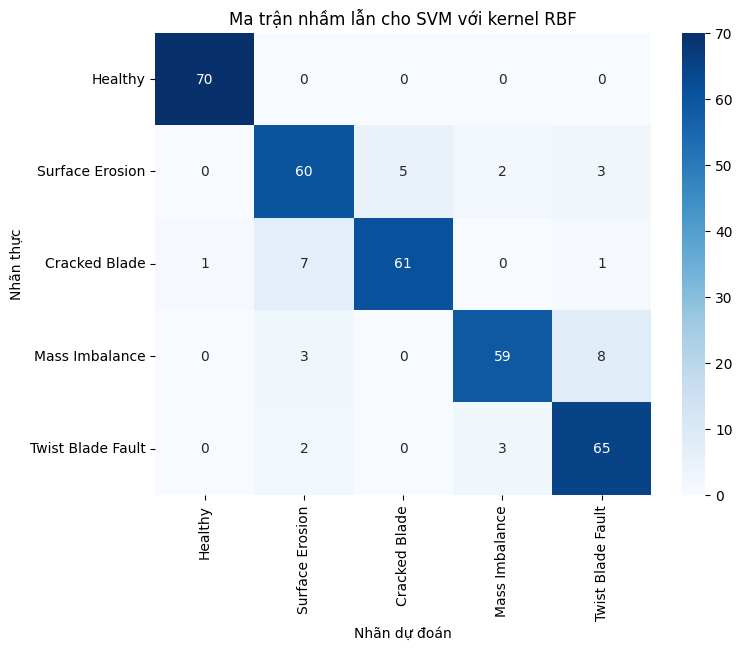

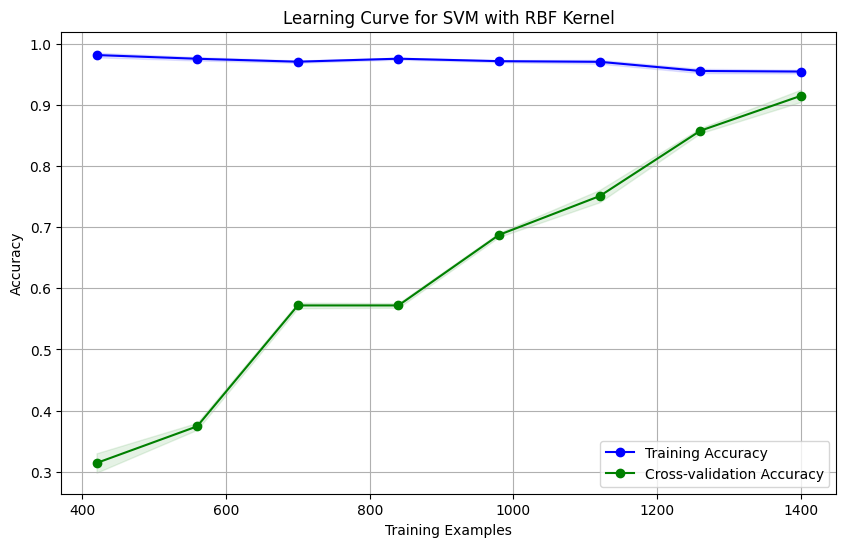

Đã lưu mô hình, scaler và PCA vào 'wind_turbine_svm_rbf_model_optimized_v5.pkl', 'wind_turbine_svm_scaler_optimized_v5.pkl' và 'wind_turbine_pca_optimized_v5.pkl'


In [31]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve, cross_val_score, StratifiedKFold
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.decomposition import PCA
from scipy import stats, fft
import random
import matplotlib.pyplot as plt

# Hàm trích xuất đặc trưng từ tín hiệu
def extract_features(sequence):
    amplitude = sequence[:, 0]  # Cột amplitude
    wind_speed = sequence[:, 1]  # Cột wind_speed

    # Đặc trưng miền thời gian
    features = []
    features.append(np.mean(amplitude))
    features.append(np.std(amplitude))
    features.append(np.max(amplitude))
    features.append(np.min(amplitude))
    features.append(stats.skew(amplitude))
    features.append(stats.kurtosis(amplitude))
    features.append(np.mean(wind_speed))
    features.append(np.std(wind_speed))

    # Thêm đặc trưng mới: Tỷ lệ biến thiên biên độ
    amplitude_diff = np.diff(amplitude)
    amplitude_variation_ratio = np.std(amplitude_diff) / (np.mean(np.abs(amplitude)) + 1e-10)
    features.append(amplitude_variation_ratio)

    # Đặc trưng miền tần số
    fft_vals = np.abs(fft.fft(amplitude))
    fft_vals = fft_vals[:len(fft_vals) // 2]
    peak_freq = np.argmax(fft_vals)
    features.append(peak_freq)
    spectral_energy = np.sum(fft_vals ** 2)
    features.append(spectral_energy)
    fft_probs = fft_vals / np.sum(fft_vals)
    spectral_entropy = -np.sum(fft_probs * np.log2(fft_probs + 1e-10))
    features.append(spectral_entropy)

    return np.array(features)

# Đọc dữ liệu
df = pd.read_csv("merged_wind_turbine_data.csv")

# Tái cấu trúc dữ liệu thành các chuỗi
sequences = []
labels = []
sequence_length = 500

for i in range(0, len(df), sequence_length):
    sequence_data = df.iloc[i:i + sequence_length]
    if len(sequence_data) == sequence_length:
        sequence = sequence_data[['amplitude', 'wind_speed']].values
        label = sequence_data['label'].iloc[0]
        sequences.append(sequence)
        labels.append(label)

sequences = np.array(sequences)
labels = np.array(labels)

# Kiểm tra phân bố nhãn ban đầu
print("Phân bố nhãn ban đầu:")
print(pd.Series(labels).value_counts())

# Tăng cường dữ liệu
augmented_sequences = []
augmented_labels = []
noise_factor = 0.02
shift_max = 50
scale_factor_range = (0.9, 1.1)

for i in range(len(sequences)):
    for _ in range(50):  # Tăng lên 50 biến thể
        # Thêm nhiễu
        noise = np.random.normal(0, noise_factor, sequences[i].shape)
        seq_noisy = sequences[i] + noise
        # Dịch chuyển thời gian
        shift = random.randint(-shift_max, shift_max)
        seq_shifted = np.roll(seq_noisy, shift, axis=0)
        # Phóng to/thu nhỏ biên độ
        scale = random.uniform(scale_factor_range[0], scale_factor_range[1])
        seq_scaled = seq_shifted.copy()
        seq_scaled[:, 0] = seq_scaled[:, 0] * scale
        # Đảo ngược tín hiệu
        if random.random() > 0.5:
            seq_scaled = np.flip(seq_scaled, axis=0)
        augmented_sequences.append(seq_scaled)
        augmented_labels.append(labels[i])

augmented_sequences = np.array(augmented_sequences)
augmented_labels = np.array(augmented_labels)

# Kiểm tra phân bố nhãn sau tăng cường
print("\nPhân bố nhãn sau tăng cường:")
print(pd.Series(augmented_labels).value_counts())

# Trích xuất đặc trưng
X_features = np.array([extract_features(seq) for seq in augmented_sequences])

# Chuẩn hóa và giảm chiều dữ liệu với PCA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_features)
pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(X_scaled)
print(f"Số đặc trưng sau PCA: {X_reduced.shape[1]}")

# Chia dữ liệu
X_train, X_test, y_train, y_test = train_test_split(X_reduced, augmented_labels, test_size=0.2, random_state=42, stratify=augmented_labels)

# Huấn luyện SVM với GridSearchCV (kernel RBF)
param_grid = {
    'C': [0.01, 0.1, 1, 10],  # Mở rộng phạm vi C
    'gamma': ['scale', 0.001, 0.01, 0.1],  # Mở rộng phạm vi gamma
    'kernel': ['rbf']
}
svm = SVC()
# Hàm kiểm tra fold hợp lệ
def get_valid_folds(X, y, n_splits=5, random_state=42, verbose=False):
    """
    Trả về danh sách các fold hợp lệ từ StratifiedKFold,
    mỗi fold đảm bảo có ít nhất 2 lớp trong cả tập train và test.
    """
    def is_valid_fold(y_subset):
        return len(np.unique(y_subset)) > 1

    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    valid_cv = []

    for i, (train_idx, test_idx) in enumerate(skf.split(X, y)):
        y_train_fold = y[train_idx]
        y_test_fold = y[test_idx]

        if is_valid_fold(y_train_fold) and is_valid_fold(y_test_fold):
            valid_cv.append((train_idx, test_idx))
            if verbose:
                print(f"✅ Fold {i + 1} hợp lệ.")
        else:
            if verbose:
                print(f"❌ Fold {i + 1} bị loại: thiếu lớp.")

    if verbose:
        print(f"\nTổng số fold hợp lệ: {len(valid_cv)}/{n_splits}")

    return valid_cv

# Sử dụng hàm trên để tạo fold hợp lệ
valid_cv = get_valid_folds(X_train, y_train, n_splits=5, verbose=True)

# Huấn luyện GridSearchCV với fold hợp lệ
grid_search = GridSearchCV(svm, param_grid, cv=valid_cv, scoring='accuracy', n_jobs=-1, error_score=np.nan)
grid_search.fit(X_train, y_train)


# In tham số tốt nhất
print("Tham số tốt nhất:", grid_search.best_params_)

# Đánh giá bằng cross-validation
best_model = grid_search.best_estimator_
cv_scores = cross_val_score(best_model, X_reduced, augmented_labels, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42), scoring='accuracy', n_jobs=-1)
print(f"\nĐộ chính xác trung bình (Cross-validation): {cv_scores.mean() * 100:.2f}%")
print(f"Độ lệch chuẩn (Cross-validation): {cv_scores.std() * 100:.2f}%")

# Dự đoán trên tập kiểm tra
y_pred = best_model.predict(X_test)

# Tính độ chính xác trên tập kiểm tra
accuracy = accuracy_score(y_test, y_pred)
print(f"\nĐộ chính xác trên tập kiểm tra: {accuracy * 100:.2f}%")

# In báo cáo phân loại
print("\nBáo cáo phân loại (tập kiểm tra):")
target_names = ["Healthy", "Surface Erosion", "Cracked Blade", "Mass Imbalance", "Twist Blade Fault"]
print(classification_report(y_test, y_pred, target_names=target_names))

# Vẽ Learning Curve
train_sizes, train_scores, test_scores = learning_curve(
    grid_search.best_estimator_, X_reduced, augmented_labels,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42), n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10), scoring="accuracy"
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Vẽ ma trận nhầm lẫn
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.title('Ma trận nhầm lẫn cho SVM với kernel RBF')
plt.xlabel('Nhãn dự đoán')
plt.ylabel('Nhãn thực')
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, label="Training Accuracy", color="blue", marker="o")
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="blue", alpha=0.1)
plt.plot(train_sizes, test_mean, label="Cross-validation Accuracy", color="green", marker="o")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="green", alpha=0.1)
plt.xlabel("Training Examples")
plt.ylabel("Accuracy")
plt.title("Learning Curve for SVM with RBF Kernel")
plt.legend(loc="best")
plt.grid()
plt.show()

# Lưu mô hình
import joblib
joblib.dump(best_model, "wind_turbine_svm_rbf_model_optimized_v5.pkl")
joblib.dump(scaler, "wind_turbine_svm_scaler_optimized_v5.pkl")
joblib.dump(pca, "wind_turbine_pca_optimized_v5.pkl")
print("Đã lưu mô hình, scaler và PCA vào 'wind_turbine_svm_rbf_model_optimized_v5.pkl', 'wind_turbine_svm_scaler_optimized_v5.pkl' và 'wind_turbine_pca_optimized_v5.pkl'")